# Workshop DL02: Convolutional Neural Networks

## Workshop Exercises

**Exercise 1**. Build your own Convolutional Neural Network for classifying CIFAR-10 images using the following network architecture:  
* convolutional layer (5x5x3 kernel, 64 filters), ReLU activation, max-pooling (2x2);  
* convolutional layer (5x5x64 kernel, 64 filters), ReLU activation, max-pooling (2x2);
* fully connected layer (388 units), ReLU activation;  
* fully connected layer (192 units), ReLU activation;  
* output layer (N_CLASSES units), softmaxed  
    
**Exercise 2**. Implement the AlexNet network architecture (https://papers.nips.cc/paper/4824-imagenet-classification-with-deep-convolutional-neural-networks.pdf).

## Convolutional Neural Networks
* https://adeshpande3.github.io/A-Beginner%27s-Guide-To-Understanding-Convolutional-Neural-Networks/
* https://ujjwalkarn.me/2016/08/11/intuitive-explanation-convnets/

## The CIFAR-10 Dataset
CIFAR-10 is a dataset consists of small (32 x 32) RGB images with 10 classes. More details and the dataset itself are available from https://www.cs.toronto.edu/~kriz/cifar.html. Download `CIFAR-10 python version`, and unpack the .zip into the same directory as this notebook (or wherever you're building your CNN).

After you've done that, feel free to use these functions to get preprocess the images for you. The point of this workshop is to focus more on building the network architecture in TensorFlow.

In [258]:
import tensorflow as tf
import numpy as np
import pickle
import matplotlib.pyplot as plt

In [259]:
DATA_PATH = "cifar-10-batches-py/"
N_PIXELS = 32 # width and height of each CIFAR image
N_CHANNELS = 3 # depth of each CIFAR image
N_CLASSES = 10 # number of classes

In [260]:
def reshape_images(raw_images):
    """
    Converts the array of raw (3072,) shaped images into an
    array of (32, 32, 3) shaped images.
    """
    images = np.array(raw_images, dtype=float) / 255.0
    images = images.reshape([-1, N_CHANNELS, N_PIXELS, N_PIXELS])
    images = images.transpose([0, 2, 3, 1])
    return images

In [261]:
def load_CIFAR_batch(path):
    """
    Loads a single CIFAR-10 batch from the given path.
    """
    with open(path, mode="rb") as f:
        raw = pickle.load(f, encoding="bytes")
        raw_images = raw[b'data']
        labels = raw[b'labels']
    return np.array(raw_images), np.array(labels)

In [262]:
def batchify(data, batch_size):
    """
    Splits a dataset into batches of the specified size.
    """
    return np.array_split(data, len(data)//batch_size)

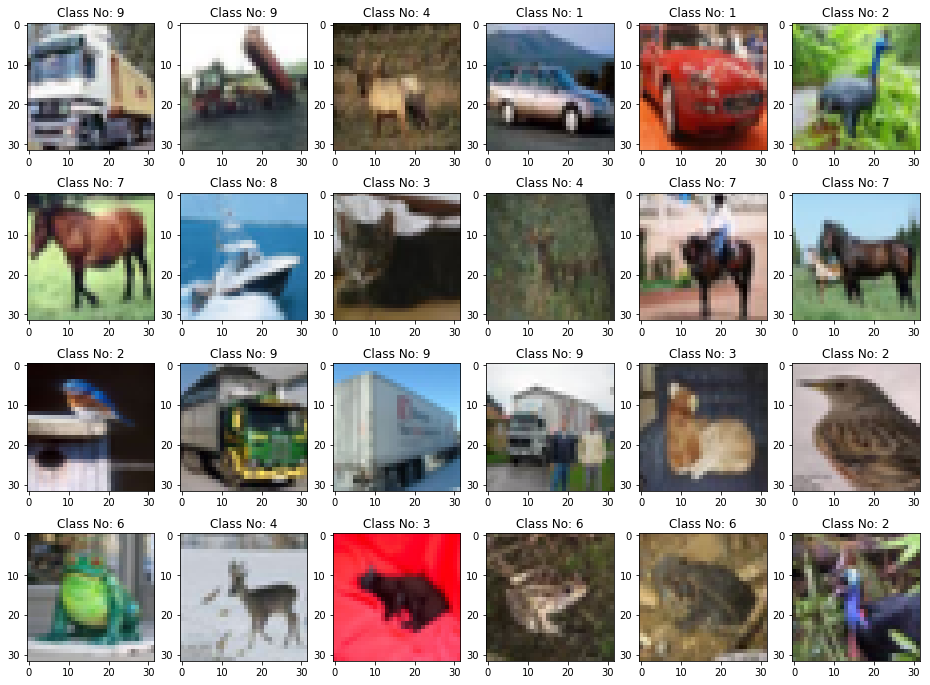

In [322]:
# just checking that all our preprocessing functions work
images, labels = load_CIFAR_batch(DATA_PATH + "data_batch_1")
images = reshape_images(images)

# creates a 4x6 plot of the first few CIFAR-10 images after preprocessing
fig = plt.figure(figsize=[16, 12])
cols = 6
rows = 4
for i in range(1, rows*cols+1):
    img = images[i]
    subplt = fig.add_subplot(rows, cols, i)
    subplt.set_title("Class No: " + str(labels[i]))
    plt.imshow(img)
plt.show()

## Worked Example: A Really Simple CNN
This is a really simple example of a CNN on CIFAR-10. You can use it as a point of reference for how to build your own CNN.

In [331]:
# training parameters
N_TRAINING_EPOCHS = 10
BATCH_SIZE = 128

In [332]:
# read raw data
images, labels = load_CIFAR_batch(DATA_PATH + "data_batch_1")
images = reshape_images(images)

# split into train and test
train_X, test_X = images[:9000], images[9000:]
train_y, test_y = labels[:9000], labels[9000:]

In [333]:
"""
Run this to reset any variables that might already be stored in the
computation graph. This because necessary when you want to make changes
to any variables inside tf.variable_scope blocks.
"""
tf.reset_default_graph()

In [334]:
# (1) define the network input
with tf.variable_scope("input"):
    X = tf.placeholder(tf.float32,
        shape=[None, N_PIXELS, N_PIXELS, N_CHANNELS])

In [335]:
# (2) define the network architecture

# 5x5x3 convolution with 16 filters
# => 32x32x16 conv layer
# => pooled 16x16x16
with tf.variable_scope("conv-layer-1") as scope:
    kernel = tf.get_variable("kernel", shape=[5,5,3,16])
    bias = tf.get_variable("biases", shape=[16])
    conv = tf.nn.conv2d(X, kernel, strides=[1,1,1,1], padding="SAME")
    conv_with_bias = tf.add(conv, bias)
    conv1 = tf.nn.relu(conv_with_bias)
    pool1 = tf.nn.max_pool(conv1, ksize=[1,3,3,1], strides=[1,2,2,1], padding="SAME")

# fully-connected layer with 100 neurons
with tf.variable_scope("dense-layer-1") as scope:
    flat = tf.reshape(pool1, [-1, 16*16*16])
    W = tf.get_variable("weights", shape=[16*16*16,100])
    b = tf.get_variable("biases", shape=[100])
    dense_with_bias = tf.matmul(flat, W) + b
    dense1 = tf.nn.relu(dense_with_bias)

In [336]:
# (3) define the network output

# output layer
with tf.variable_scope("softmax-output") as scope:
    W = tf.get_variable("weights", shape=[100,N_CLASSES])
    b = tf.get_variable("biases", shape=[N_CLASSES])
    y_pre_softmax = tf.matmul(dense1, W) + b
    y_ = tf.nn.softmax(y_pre_softmax)

In [337]:
# (4) define the network loss
with tf.variable_scope("loss"):
    y = tf.placeholder(tf.int64, shape=[None, ])
    y_one_hot = tf.one_hot(indices=y, depth=N_CLASSES)
    cross_entropy = tf.nn.softmax_cross_entropy_with_logits_v2(
        logits=y_pre_softmax, labels=y_one_hot)
    loss = tf.reduce_mean(cross_entropy)

In [338]:
# (5) define the network optimizer
with tf.variable_scope("optimizer"):
    optimizer = tf.train.AdamOptimizer(1e-4).minimize(loss)

In [339]:
# (6) define evaluation metrics
with tf.variable_scope("evaluation"):
    correct = tf.equal(tf.argmax(y_, 1), y)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))

In [340]:
# (7) train the network
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    
    for epoch in range(N_TRAINING_EPOCHS):
        
        # for large data sets, you have to split your data into
        # batches for training, or tensorflow will take up all the
        # memory on your machine
        batches_X = batchify(images, 128)
        batches_y = batchify(labels, 128)
        
        for i in range(len(batches_X)):
            _, epoch_loss = sess.run([optimizer, loss],
                feed_dict={X: batches_X[i], y: batches_y[i]})

        epoch_accuracy = sess.run(accuracy,
            feed_dict={X: test_X, y: test_y})
        print("========================================================")
        print("Epoch " + str(epoch) + " completed.")
        print("Loss: " + str(epoch_loss))
        print("Accu: " + str(epoch_accuracy))
        print("========================================================\n")

Epoch 0 completed.
Loss: 2.0460036
Accu: 0.3

Epoch 1 completed.
Loss: 1.9334377
Accu: 0.344

Epoch 2 completed.
Loss: 1.8682979
Accu: 0.374

Epoch 3 completed.
Loss: 1.8176008
Accu: 0.396

Epoch 4 completed.
Loss: 1.7787805
Accu: 0.401

Epoch 5 completed.
Loss: 1.7311275
Accu: 0.412

Epoch 6 completed.
Loss: 1.6943481
Accu: 0.429

Epoch 7 completed.
Loss: 1.666446
Accu: 0.444

Epoch 8 completed.
Loss: 1.6357796
Accu: 0.456

Epoch 9 completed.
Loss: 1.599084
Accu: 0.464



## Reference List
* Learning Multiple Layers of Features from Tiny Images, Alex Krizhevsky, 2009. (This is the source of the CIFAR-10 dataset)

## Discarded: Ignore This

In [280]:
# (2) define the network architecture

# 5x5x3 convolution with 64 filters
# => 32x32x64 conv layer
# => pooled 16x16x64
with tf.variable_scope("conv-layer-1") as scope:
    kernel = tf.get_variable("kernel", shape=[5,5,3,64])
    bias = tf.get_variable("biases", shape=[64])
    conv = tf.nn.conv2d(X, kernel, strides=[1,1,1,1], padding="SAME")
    conv_with_bias = tf.add(conv, bias)
    conv1 = tf.nn.relu(conv_with_bias)
    pool1 = tf.nn.max_pool(conv1, ksize=[1,3,3,1], strides=[1,2,2,1], padding="SAME")

# 5x5x64 convolution with 64 filters
# => 16x16x64 conv layer
# => pooled 8x8x64
with tf.variable_scope("conv-layer-2") as scope:
    kernel = tf.get_variable("kernel", shape=[5,5,64,64])
    bias = tf.get_variable("biases", shape=[64])
    conv = tf.nn.conv2d(pool1, kernel, strides=[1,1,1,1], padding="SAME")
    conv_with_bias = tf.add(conv, bias)
    conv2 = tf.nn.relu(conv_with_bias)
    pool2 = tf.nn.max_pool(conv2, ksize=[1,3,3,1], strides=[1,2,2,1], padding="SAME")
    
# fully-connected layer with 384 neurons
with tf.variable_scope("dense-layer-1") as scope:
    flat = tf.reshape(pool2, [-1, 8*8*64])
    W = tf.get_variable("weights", shape=[8*8*64,384])
    b = tf.get_variable("biases", shape=[384])
    dense_with_bias = tf.matmul(flat, W) + b
    dense1 = tf.nn.relu(dense_with_bias)
    
# fully-connected layer with 192 neurons
with tf.variable_scope("dense-layer-2") as scope:
    W = tf.get_variable("weights", shape=[384,192])
    b = tf.get_variable("biases", shape=[192])
    dense_with_bias = tf.matmul(dense1, W) + b
    dense2 = tf.nn.relu(dense_with_bias)

In [281]:
# (3) define the network output

# output layer
with tf.variable_scope("softmax-output") as scope:
    W = tf.get_variable("weights", shape=[192,N_CLASSES])
    b = tf.get_variable("biases", shape=[N_CLASSES])
    y_pre_softmax = tf.matmul(dense2, W) + b
    y_ = tf.nn.softmax(y_pre_softmax)